Copyright © 2025 Technical University of Denmark

In [1]:
from lcg_plus.states.from_sf import prepare_gkp_bosonic
from lcg_plus.states.nongauss import prepare_fock_coherent, prepare_sqz_cat_coherent, prepare_gkp_nonlinear_sqz
import numpy as np
from thewalrus.symplectic import rotation
from matplotlib import pyplot as plt
import matplotlib as mpl
from time import time
from copy import copy

from lcg_plus.sampling import *


colwidth = 3.41667
fs = 12
mpl.rcParams.update({'font.size': fs, 
                     "text.usetex":  True, 
                     'font.family':'serif',
                     'xtick.labelsize': 10, 
                     'ytick.labelsize':10 })

fig_kwargs = {'dpi':800, 'bbox_inches': 'tight'}

In [16]:
def make_sampling_plot(axes, vals, reject_vals, state, 
                       axis = 0, norm = 1, method = 'normal', factor=0 , covmat = []):

    modes = [0]
    means_quad, covs_quad, quad_ind = select_quads(state, [0], covmat)

    if method != 'gaussian':
        ub_ind, ub_weights, ub_weights_prob = get_upbnd_weights(means_quad, covs_quad, state.log_weights, method)
    else:
        cov_ub, mean_ub, scale = get_upbnd_gaussian(state, means_quad, covs_quad, quad_ind)
        
        prefactor = 1/np.sqrt(2*np.pi*np.linalg.det(cov_ub))
        if factor == 0:
            ub_weight = np.log(scale/prefactor)
        else:
            ub_weight = np.log(factor)
        
        
    no_samples = len(vals)

    if np.shape(vals[-1]) == (2,):
        n,b,p = axes.hist(vals[:,0],bins = 100, density =True, alpha = 0.9, label = 'accepted samples')
        n,b,p = axes.hist(reject_vals[:,0],bins=100, 
                             density =True, alpha = 0.5, label='rejected samples')
    else:
        n,b,p = axes.hist(vals, bins = 100, density =True, alpha = 0.9, label = 'accepted samples')
        n,b,p = axes.hist(reject_vals,bins=100, 
                             density =True, alpha = 0.5, label='rejected samples')


    #v = np.concatenate((vals, reject_vals), axis = 0)
    v = vals
    x= np.linspace(np.min(v), np.max(v),500)
        
    dx = np.diff(x)[-1]
    #W = state.get_wigner_bosonic(x,x)
    #px = np.sum(W, axis = axis)*dx
    #axes.plot(x, px, label = 'marginal')
    prob = np.zeros(len(x))
    ub_prob = np.zeros(len(x))
    for i, xval in enumerate(x):
        prob[i] = generaldyne_probability(xval, means_quad, covs_quad, state.log_weights).real
        
        if method != 'gaussian':
            ub_prob[i] = generaldyne_probability(xval, means_quad[ub_ind,:].real, covs_quad, ub_weights).real
        else:
            ub_prob[i] = generaldyne_probability(xval, mean_ub, cov_ub, ub_weight).real

        
    axes.plot(x, prob, 'k--',label = r'$p(m)$')
    print('sum p(m)', np.sum(prob)*np.diff(x)[0])
    
    axes.plot(x, ub_prob, 'r--', label = 'upper bounding f.')
    print('sum prob_upbnd', np.sum(ub_prob)*np.diff(x)[0])
    
    #axes.set_xlabel(r'$m$')
    #axes.set_ylabel(r'Function value')
    axes.grid('on')
    #axes.legend()
    axes.set_ylim([0,1])
    axes.set_xlim([np.min(v),np.max(v)])


no. of weights 231
num k 21
success rate 0.0022570102739107667
time sampling with normal 20.51707100868225
sum p(m) 0.9955888631845418
sum prob_upbnd 465.57578840072887


/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_27614/1893611224.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob[i] = generaldyne_probability(xval, means_quad, covs_quad, state.log_weights).real
/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_27614/1893611224.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ub_prob[i] = generaldyne_probability(xval, means_quad[ub_ind,:].real, covs_quad, ub_weights).real


success rate 0.005299641744218091
time sampling with ignore_imag_prefactor 8.794080018997192
sum p(m) 0.9955068299034929
sum prob_upbnd 210.39420751200572
success rate 0.01646009250571988
time sampling with coherent 5.372729778289795
sum p(m) 0.9980822688079031
sum prob_upbnd 61.09544523556492
success rate 0.12780097128738177
time sampling with gaussian 1.8066432476043701
sum p(m) 0.9996557458104912
sum prob_upbnd 7.874032101994637


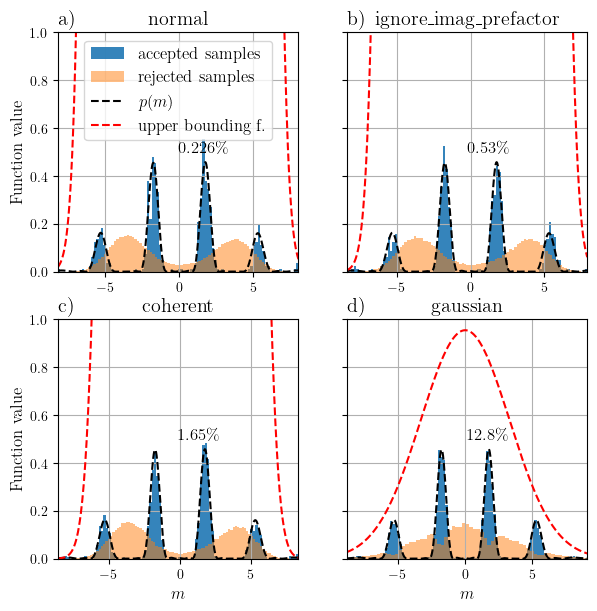

In [17]:
### Compare homodyne sampling methods

fig, axes = plt.subplots(2,2, figsize=(2*colwidth, 2*colwidth), sharey=True)

#Choose the state to sample
n = 20
gkp = prepare_gkp_nonlinear_sqz(n, 's1',inf = 1e-4, fast =True)
print('no. of weights', gkp.num_weights)
print('num k', gkp.num_k)

scale = np.sqrt(np.pi*n)  # For gaussian method


methods = ['normal', 'ignore_imag_prefactor', 'coherent', 'gaussian']
shots = [500, 500, 1000, 3000]

for i, method in enumerate(methods): 
    t0 = time()
    if method == 'gaussian':
        samples, reject_samples = gkp.sample_dyne_gaussian([0], shots = shots[i], factor = scale)
    else:
        samples, reject_samples = gkp.sample_dyne([0], shots = shots[i], method = method)
    t1 = time()
    sr = len(samples)/(len(samples)+len(reject_samples))
    print('success rate', sr)
    print(f'time sampling with {method}', t1-t0)

    #Axes coords
    if i == 0:
        ax = axes[0,0]
    elif i ==1:
        ax = axes[0,1]
    elif i == 2:
        ax = axes[1,0]
    elif i == 3:
        ax = axes[1,1]
    
    make_sampling_plot(ax, samples, reject_samples, gkp, method =method, factor = scale)
    ax.text(0.5,0.5,r'${:.3} \%$'.format(sr*100),transform=ax.transAxes)


axes[0,0].set_title('a)', loc = 'left')
axes[0,0].set_title('normal')
axes[0,0].legend()
axes[0,0].set_ylabel('Function value')
axes[0,1].set_title('b)', loc = 'left')
axes[0,1].set_title('ignore_imag_prefactor')
axes[1,0].set_title('c)', loc = 'left')
axes[1,0].set_title('coherent')
axes[1,0].set_ylabel('Function value')
axes[1,1].set_title('d)', loc = 'left')
axes[1,1].set_title('gaussian')
axes[1,0].set_xlabel(r'$m$')
axes[1,1].set_xlabel(r'$m$')
#plt.savefig('thesis_figures/sample_gkp.pdf',**fig_kwargs)
plt.show()


In [ ]:
fig, axes = plt.subplots(2,2, figsize=(2*colwidth, 2*colwidth), sharey=True)

#Choose the state to sample
n = 20
fock = prepare_fock_coherent(n)
print('no. of weights', fock.num_weights)
print('num k', fock.num_k)

scale = np.sqrt(np.pi*n)  # For gaussian method


methods = ['normal', 'ignore_imag_prefactor', 'coherent', 'gaussian']
shots = [500, 500, 1000, 3000]

for i, method in enumerate(methods): 
    t0 = time()
    if method == 'gaussian':
        samples, reject_samples = fock.sample_dyne_gaussian([0], shots = shots[i], factor = scale)
    else:
        samples, reject_samples = fock.sample_dyne([0], shots = shots[i], method = method)
    t1 = time()
    sr = len(samples)/(len(samples)+len(reject_samples))
    print('success rate', sr)
    print(f'time sampling with {method}', t1-t0)

    #Axes coords
    if i == 0:
        ax = axes[0,0]
    elif i ==1:
        ax = axes[0,1]
    elif i == 2:
        ax = axes[1,0]
    elif i == 3:
        ax = axes[1,1]
    
    make_sampling_plot(ax, samples, reject_samples, fock, method =method, factor = scale)
    ax.text(0.5,0.5,r'${:.3} \%$'.format(sr*100),transform=ax.transAxes)


axes[0,0].set_title('a)', loc = 'left')
axes[0,0].set_title('normal')
axes[0,0].legend()
axes[0,0].set_ylabel('Function value')
axes[0,1].set_title('b)', loc = 'left')
axes[0,1].set_title('ignore_imag_prefactor')
axes[1,0].set_title('c)', loc = 'left')
axes[1,0].set_title('coherent')
axes[1,0].set_ylabel('Function value')
axes[1,1].set_title('d)', loc = 'left')
axes[1,1].set_title('gaussian')
axes[1,0].set_xlabel(r'$m$')
axes[1,1].set_xlabel(r'$m$')
axes[0,0].set_ylim([0,0.6])
#plt.savefig('thesis_figures/sample_fock.pdf',**fig_kwargs)

/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/lcg_plus/states/coherent.py:143: RuntimeWarning: divide by zero encountered in log
  bn = np.log(np.sqrt(factorial(ns)) / eps** ns * coeffs[:,np.newaxis])


no. of weights 55
num k 10
success rate 0.0002919145507726978
time sampling with normal 30.31520700454712
sum p(m) 0.9881845922593873
sum prob_upbnd 3146.4399953409165


/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_27614/1893611224.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob[i] = generaldyne_probability(xval, means_quad, covs_quad, state.log_weights).real
/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_27614/1893611224.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ub_prob[i] = generaldyne_probability(xval, means_quad[ub_ind,:].real, covs_quad, ub_weights).real


success rate 0.0006191413747415085
time sampling with ignore_imag_prefactor 13.986596822738647
sum p(m) 0.9877002045248539
sum prob_upbnd 1797.696196733816
success rate 0.0018093652746616487
time sampling with coherent 4.772737979888916
sum p(m) 0.9872175435284934
sum prob_upbnd 547.208692805404
success rate 0.17433751743375175
time sampling with gaussian 0.40786004066467285
sum p(m) 0.9987431862573181
sum prob_upbnd 5.467017297137121


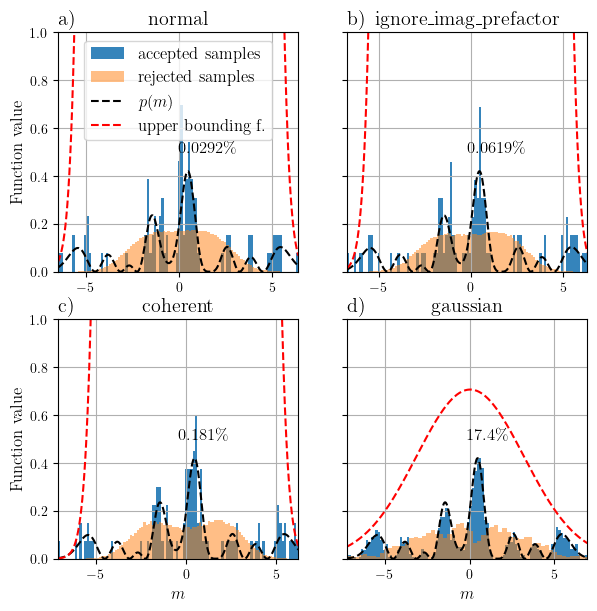

In [5]:
### Compare homodyne sampling methods

fig, axes = plt.subplots(2,2, figsize=(2*colwidth, 2*colwidth), sharey=True)

#Choose the state to sample
n = 10

from lcg_plus.states.coherent import gen_fock_superpos_coherent
from lcg_plus.base import State

coeffs = np.zeros(n)
coeffs[0] = 1
coeffs[-1] =1 
data = gen_fock_superpos_coherent(coeffs, infid = 1e-4)
state = State()
state.update_data(data)
state.get_norm()

print('no. of weights', state.num_weights)
print('num k', state.num_k)

scale = np.sqrt(np.pi*n)  # For gaussian method


methods = ['normal', 'ignore_imag_prefactor', 'coherent', 'gaussian']
shots = [100,100,100,1000]

for i, method in enumerate(methods): 
    t0 = time()
    if method == 'gaussian':
        samples, reject_samples = state.sample_dyne_gaussian([0], shots = shots[i], factor = scale)
    else:
        samples, reject_samples = state.sample_dyne([0], shots = shots[i], method = method)
    t1 = time()
    sr = len(samples)/(len(samples)+len(reject_samples))
    print('success rate', sr)
    print(f'time sampling with {method}', t1-t0)

    #Axes coords
    if i == 0:
        ax = axes[0,0]
    elif i ==1:
        ax = axes[0,1]
    elif i == 2:
        ax = axes[1,0]
    elif i == 3:
        ax = axes[1,1]
    
    make_sampling_plot(ax, samples, reject_samples, state, method =method, factor = scale)
    ax.text(0.5,0.5,r'${:.3} \%$'.format(sr*100),transform=ax.transAxes)


axes[0,0].set_title('a)', loc = 'left')
axes[0,0].set_title('normal')
axes[0,0].legend()
axes[0,0].set_ylabel('Function value')
axes[0,1].set_title('b)', loc = 'left')
axes[0,1].set_title('ignore_imag_prefactor')
axes[1,0].set_title('c)', loc = 'left')
axes[1,0].set_title('coherent')
axes[1,0].set_ylabel('Function value')
axes[1,1].set_title('d)', loc = 'left')
axes[1,1].set_title('gaussian')
axes[1,0].set_xlabel(r'$m$')
axes[1,1].set_xlabel(r'$m$')
plt.savefig('thesis_figures/sample_on.pdf',**fig_kwargs)
plt.show()


551
0.3157670497894287
success rate 1.9723865877712032
sum p(m) 0.9992163498296665
sum prob_upbnd 1.498209028623147


/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_23190/2869056598.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob[i] = generaldyne_probability(xval, means_quad, covs_quad, state.log_weights).real
/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_23190/2869056598.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ub_prob[i] = generaldyne_probability(xval, means_quad[ub_ind,:].real, covs_quad, ub_weights).real


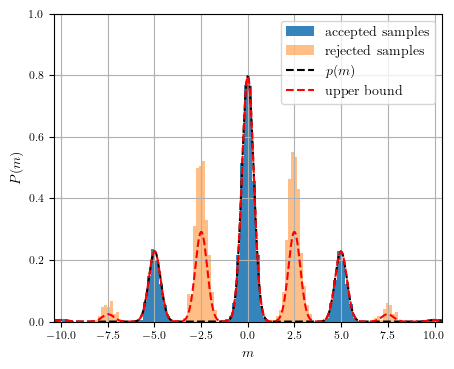

In [31]:
gkp_bosonic = prepare_gkp_bosonic([0,0], 0.1)
print(gkp_bosonic.num_weights)

fig, ax = plt.subplots(1,1,figsize=(colwidth,colwidth))

t0 = time()
samples,reject_samples = gkp_bosonic.sample_dyne([0], shots = 2000)
t1 = time()
print(t1-t0)
print('success rate', len(samples)/len(reject_samples)+len(samples))
make_sampling_plot(ax, samples, reject_samples, gkp_bosonic)

